In [2]:
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sb
import warnings
import pymc3 as pm
%matplotlib inline

In [3]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

In [4]:
X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2],
                                                       [1,1.5])])
X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(beta_real, X) + eps_real

In [5]:
X.shape,y.shape

((2, 100), (100,))

In [6]:
def scatter_plot(x, y):
    pl.figure(figsize=(10,10))
    for idx, x_i in enumerate(x):
        pl.subplot(2,2,idx+1)
        pl.scatter(x_i, y)
        pl.xlabel('$x_{}$'.format(idx), fontsize=16)
        pl.ylabel('$y$'.format(idx), rotation=0, fontsize=16)
    pl.subplot(2,2,idx+2)
    pl.scatter(x[0], x[1])
    pl.xlabel('$x_{}$'.format(idx-1), fontsize=16)
    pl.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

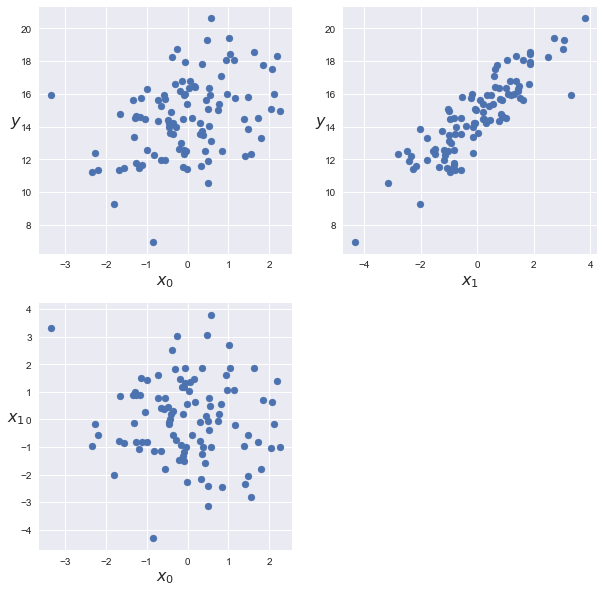

In [7]:
scatter_plot(X_centered, y)

Optimization terminated successfully.
         Current function value: 74.986175
         Iterations: 23
         Function evaluations: 31
         Gradient evaluations: 31


100%|██████████| 5000/5000 [00:08<00:00, 564.35it/s] 


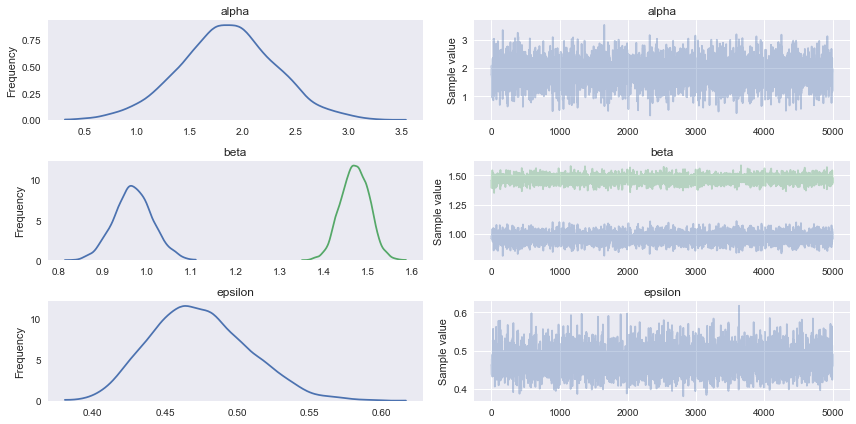

In [8]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha_tmp + pm.math.dot(beta, X_centered)
    alpha = pm.Deterministic('alpha',
                             alpha_tmp - pm.math.dot(beta, X_mean))
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_mlr = pm.sample(5000, step=step, start=start)
    varnames = ['alpha', 'beta', 'epsilon']
    pm.traceplot(trace_mlr, varnames)

In [9]:
pm.df_summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,1.853291,0.453241,0.005994,0.905561,2.715610
beta__0,0.968490,0.043568,0.000580,0.882128,1.055156
beta__1,1.470068,0.032123,0.000451,1.406743,1.530762
epsilon,0.473777,0.033746,0.000504,0.412590,0.540149


***
###  Confounding variables
 or 
 **how a multiple linear regression model reacts to redundant variables and the importance of considering possible confounding variables**

In [17]:
N=100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

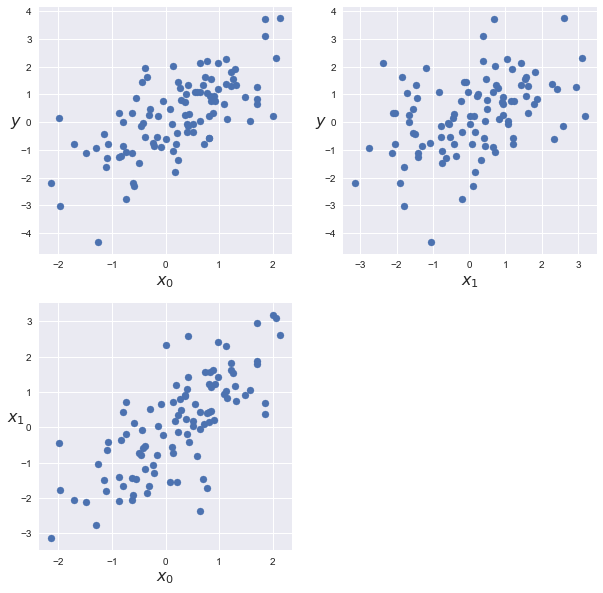

In [18]:
scatter_plot(X, y)

In [19]:
with pm.Model() as model_red:
    # priors
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    # likelihood
    mu = alpha + pm.math.dot(beta,X)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    #mcmc setup
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_red = pm.sample(5000, step=step, start=start)

Optimization terminated successfully.


100%|██████████| 5000/5000 [00:07<00:00, 690.61it/s] 

         Current function value: 153.808928
         Iterations: 14
         Function evaluations: 18
         Gradient evaluations: 18


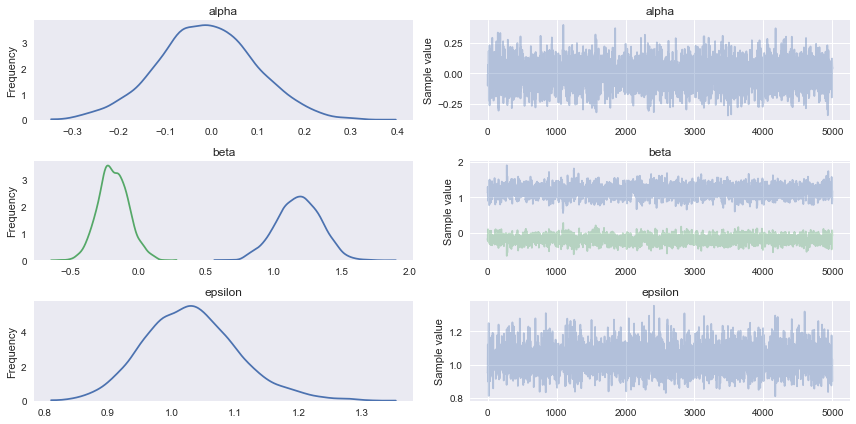

In [20]:
pm.traceplot(trace_red);

In [21]:
pm.df_summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.010433,0.105400,0.001731,-0.210699,0.204529
beta__0,1.183444,0.162301,0.004189,0.859791,1.487450
beta__1,-0.182425,0.111518,0.002694,-0.396647,0.041379
epsilon,1.030627,0.074199,0.001125,0.894971,1.186522


so $\beta_1$ has very little influence

Exercise:
1. rerun the above, excluding x_2
2. rerun the above, excluding x_1

In [22]:
with pm.Model() as model_red_x1:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10,)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha + beta*x_1
    y_pred = pm.Normal('y_pred_x1', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_red_x1 = pm.sample(5000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 151.897648
         Iterations: 10


100%|██████████| 5000/5000 [00:05<00:00, 945.98it/s] 

         Function evaluations: 16
         Gradient evaluations: 16


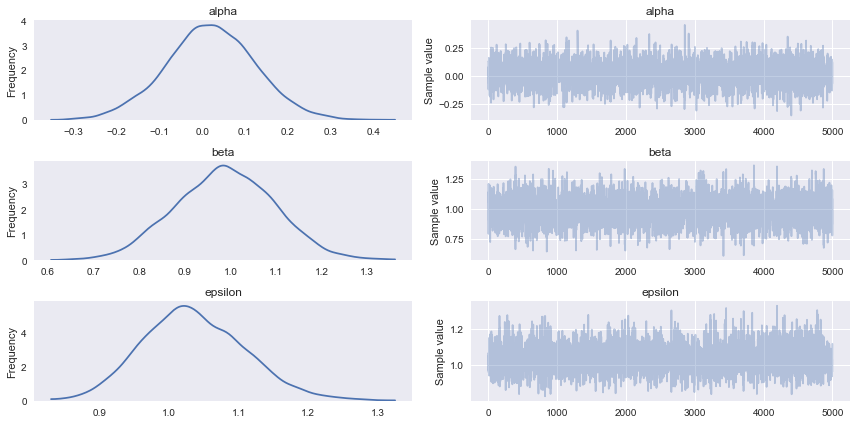

In [24]:
pm.traceplot(trace_red_x1);

In [25]:
pm.df_summary(trace_red_x1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.018520,0.104653,0.001576,-0.188502,0.221962
beta,0.986900,0.109462,0.001521,0.776267,1.198944
epsilon,1.036434,0.073715,0.001259,0.901486,1.186032


In [30]:
with pm.Model() as model_red_x2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha + beta*x_2
    y_pred=  pm.Normal('y_pred_x2', mu=mu, sd=epsilon, observed=y)
    start=pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_red_x2 = pm.sample(5000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 172.866119
         Iterations: 12
         Function evaluations: 16


100%|██████████| 5000/5000 [00:05<00:00, 988.12it/s] 

         Gradient evaluations: 16


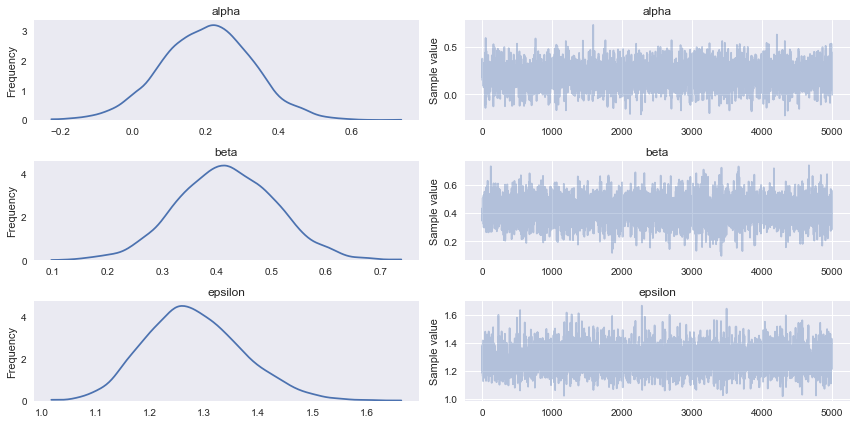

In [31]:
pm.traceplot(trace_red_x2);

In [32]:
pm.df_summary(trace_red_x2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.200877,0.123704,0.001633,-0.047149,0.443277
beta,0.417904,0.090589,0.001382,0.243826,0.598853
epsilon,1.280865,0.089621,0.001399,1.122007,1.465593


In conclusion, $\beta_1$ is lower for the multiple linear regression than for the simple linear regression. In other words, the ability of x_1 to explain y is lower (maybe even null) when x_0 is included in the model.


Next we look at the impact of strong correlation between exogenous variables. To study this problem and its consequences for our inference, we will use the same synthetic data and model as before, but now we will increase the degree of correlation between x_1 and x_2 by decreasing the scale of the random noise we add to x_1 to obtain x_2, that is:

In [34]:
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

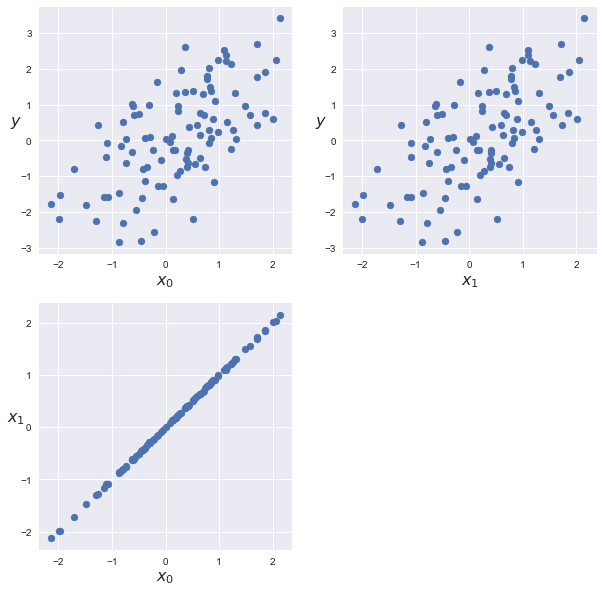

In [35]:
scatter_plot(X,y)

In [36]:
with pm.Model() as model_red2:
    # priors
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    # likelihood
    mu = alpha + pm.math.dot(beta,X)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    #mcmc setup
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_red = pm.sample(5000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 159.638866


100%|██████████| 5000/5000 [00:49<00:00, 100.25it/s]

         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23


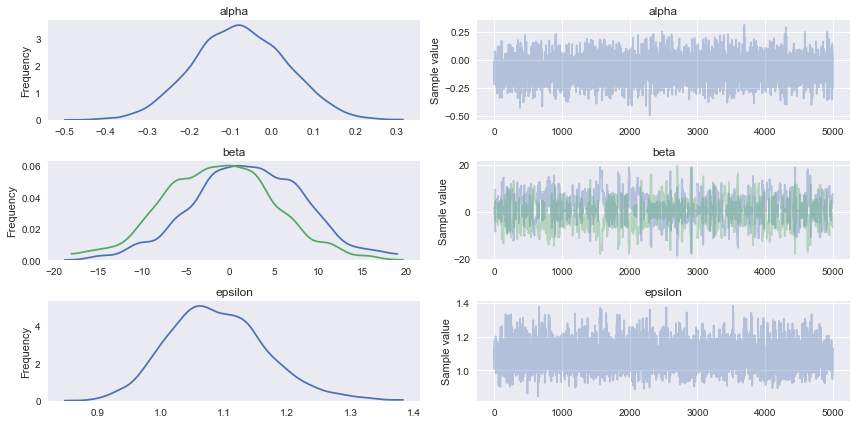

In [38]:
pm.traceplot(trace_red);

In [39]:
pm.df_summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.078306,0.110997,0.001897,-0.289166,0.138914
beta__0,2.086282,6.288219,0.324797,-10.896388,14.239379
beta__1,-1.188075,6.274767,0.324116,-13.341804,11.718157
epsilon,1.088776,0.077468,0.001297,0.941734,1.244735


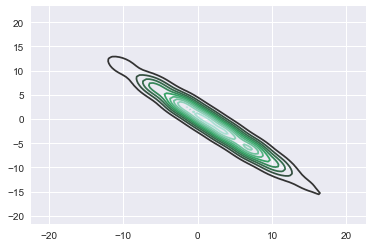

In [44]:
sb.kdeplot(trace_red['beta'][:,0],trace_red['beta'][:,1])

In [43]:
trace_red['beta'].shape

(5000, 2)

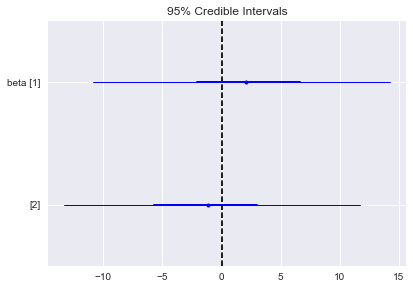

In [48]:
pm.forestplot(trace_red, varnames=['beta'])